In [1]:
import sys 
sys.path.append('../..')
from cox.utils import Parameters
from cox.store import Store
from cox.readers import CollectionReader
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import itertools
import numpy as np
import torch as ch
from torch import Tensor
import torch.nn as nn
from torch.distributions import Gumbel, Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.utils.data import TensorDataset, DataLoader
import torch.nn.functional as F
from delphi.utils import constants as consts
from delphi import oracle
from delphi import train
from delphi.utils import defaults
import datetime

# Store Information, etc

In [2]:
STORE_PATH = '/home/pstefanou/MultinomialLogisticRegression'
STORE_TABLE_NAME = 'multi_log_reg'

store = Store(STORE_PATH)

store.add_table(STORE_TABLE_NAME, { 
    'delphi_cos': float,
    'mle_cos': float,
    'alpha': float, 
    'C': float,
})

Logging in: /home/pstefanou/LogisticRegression/5b31e98e-45d5-4775-b2ac-635e2e34fd3f


# Standard Gumbel Distribution

(array([  4.,   4.,   5.,  23.,  27.,  63.,  69.,  91., 153., 185., 226.,
        261., 283., 326., 352., 395., 386., 399., 426., 391., 399., 388.,
        414., 367., 333., 337., 313., 319., 297., 260., 238., 212., 201.,
        201., 165., 137., 126., 115., 104., 101.,  97.,  97.,  76.,  65.,
         59.,  46.,  48.,  43.,  35.,  41.,  46.,  29.,  25.,  24.,  23.,
         12.,  15.,  12.,  10.,  11.,   9.,   9.,  12.,   6.,   5.,   5.,
          2.,   4.,   3.,   1.,   5.,   7.,   2.,   2.,   4.,   1.,   2.,
          3.,   1.,   0.,   1.,   1.,   2.,   1.,   0.,   0.,   0.,   1.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([-2.1231728 , -2.010586  , -1.8979993 , -1.7854125 , -1.6728258 ,
        -1.5602391 , -1.4476523 , -1.3350655 , -1.2224787 , -1.109892  ,
        -0.9973053 , -0.88471854, -0.7721318 , -0.65954506, -0.5469583 ,
        -0.43437156, -0.32178482, -0.20919807, -0.09661133,  0.01597542,
         0.12856217,  0.24

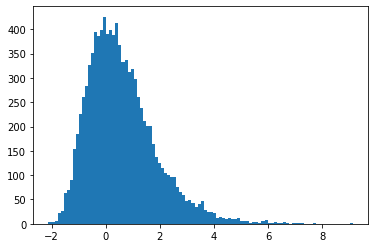

In [2]:
G = Gumbel(0, 1)

samples = G.sample(ch.Size([10000, 1])).T
plt.hist(samples, bins=100)

## Default Experiment Parameters

In [181]:
# procedure hyperparameters
args = Parameters({ 
    'epochs': 25,
    'num_workers': 0, 
    'batch_size': 100,
    'bias': True,
    'num_samples': 100,
    'clamp': True, 
    'radius': 5.0, 
    'var_lr': 1e-2,
    'lr': 1e-1,
    'shuffle': False, 
    'tol': 1e-2,
    'custom_lr_multiplier': consts.COSINE,
    'samples': 10000,  # number of samples to generate for ground truth
    'in_features': 2, # number of in-features to multi-log-reg
    'k': 2, # number of classes
    'lower': -1, # lower bound for generating ground truth weights
    'upper': 1,  # upper bound for generating ground truth weights
    'custom_criterion': F.gumbel_softmax,
})

# args = defaults.check_and_fill_args(train_kwargs, defaults.TRAINING_ARGS, CIFAR)

# Multinomial Logistic Regression

In [190]:
# generate ground-truth from uniform distribution
U = Uniform(args.lower, args.upper)
ground_truth = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)
ground_truth.weight = nn.Parameter(U.sample(ch.Size([args.K, args.IN_FEATURES])))
if ground_truth.bias is not None: 
    ground_truth.bias = nn.Parameter(U.sample(ch.Size([args.K,])))
print("ground truth weights: {}".format(ground_truth.weight))
print("ground truth bias: {}".format(ground_truth.bias))
# independent variable 
U_ = Uniform(-5, 5)
X = U_.sample(ch.Size([args.samples, args.IN_FEATURES]))
# determine base model logits 
z = ground_truth(X)
# apply softmax to unnormalized likelihoods
y = ch.argmax(ch.nn.Softmax(dim=1)(z), dim=1)

ground truth weights: Parameter containing:
tensor([[ 0.9522,  0.5150],
        [-0.0285, -0.8598]], requires_grad=True)
ground truth bias: Parameter containing:
tensor([-0.7007,  0.4381], requires_grad=True)


# Untruncated Experiment

In [183]:
gumbel = Gumbel(0, 1)

class GumbelCE(ch.autograd.Function):
    @staticmethod
    def forward(ctx, pred, targ):
        ctx.save_for_backward(pred, targ)
        loss = ch.nn.CrossEntropyLoss()
        return loss(pred, targ)

    @staticmethod
    def backward(ctx, grad_output):
        pred, targ = ctx.saved_tensors
        # retain logits of kth class
        stacked = pred[None, ...].repeat(args.num_samples, 1, 1)        
        # add noise to logits
        noised = stacked + gumbel.sample(stacked.size())
        out = noised.mean(dim=0)
        # calculate gradient 
        grad = 1 - ch.exp(-out)
        return grad / pred.size(0), -grad / pred.size(0)

In [191]:
emp_multi_log_reg = nn.Linear(in_features=args.IN_FEATURES, out_features=args.K, bias=args.bias)

In [192]:
ds = TensorDataset(X, y)
loader = DataLoader(ds, num_workers=args.num_workers, batch_size=args.batch_size)
# criterion = GumbelCE.apply
criterion = nn.CrossEntropyLoss()
optimizer = ch.optim.SGD(emp_multi_log_reg.parameters(), lr=1e-1)
scheduler = ch.optim.lr_scheduler.CosineAnnealingLR(optimizer, args.epochs)

In [193]:
print("empirical weight estimates: {}".format(emp_multi_log_reg.weight))
print("empirical bias estimates: {}".format(emp_multi_log_reg.bias))

empirical weight estimates: Parameter containing:
tensor([[-0.0747,  0.4156],
        [ 0.0777,  0.0465]], requires_grad=True)
empirical bias estimates: Parameter containing:
tensor([-0.3530,  0.3344], requires_grad=True)


In [194]:
for epoch in range(args.epochs): 
    for batch_X, batch_y in loader: 
        optimizer.zero_grad()
        pred = emp_multi_log_reg(batch_X)
        loss = criterion(pred,  batch_y)
        loss.backward()
        print("----")
        print("grad: {}".format(emp_multi_log_reg.weight.grad))
        optimizer.step()
        scheduler.step()

----
grad: tensor([[-0.9941, -0.4296],
        [ 0.9941,  0.4296]])
----
grad: tensor([[-0.4716, -0.3199],
        [ 0.4716,  0.3199]])
----
grad: tensor([[-0.4135, -0.2377],
        [ 0.4135,  0.2377]])
----
grad: tensor([[-0.2791, -0.1934],
        [ 0.2791,  0.1934]])
----
grad: tensor([[-0.1557, -0.2625],
        [ 0.1557,  0.2625]])
----
grad: tensor([[-0.2019, -0.1730],
        [ 0.2019,  0.1730]])
----
grad: tensor([[-0.2041, -0.1740],
        [ 0.2041,  0.1740]])
----
grad: tensor([[-0.1045, -0.1404],
        [ 0.1045,  0.1404]])
----
grad: tensor([[-0.1741, -0.0997],
        [ 0.1741,  0.0997]])
----
grad: tensor([[-0.2854, -0.0151],
        [ 0.2854,  0.0151]])
----
grad: tensor([[-0.0949, -0.1779],
        [ 0.0949,  0.1779]])
----
grad: tensor([[-0.2287, -0.0677],
        [ 0.2287,  0.0677]])
----
grad: tensor([[-0.2494, -0.0503],
        [ 0.2494,  0.0503]])
----
grad: tensor([[-0.0841, -0.1387],
        [ 0.0841,  0.1387]])
----
grad: tensor([[-0.0446, -0.1806],
        [

grad: tensor([[-0.0505,  0.0227],
        [ 0.0505, -0.0227]])
----
grad: tensor([[-0.0073, -0.0230],
        [ 0.0073,  0.0230]])
----
grad: tensor([[-0.0645,  0.0248],
        [ 0.0645, -0.0248]])
----
grad: tensor([[-0.0232, -0.0284],
        [ 0.0232,  0.0284]])
----
grad: tensor([[-0.0216, -0.0167],
        [ 0.0216,  0.0167]])
----
grad: tensor([[-0.0127, -0.0451],
        [ 0.0127,  0.0451]])
----
grad: tensor([[-0.1847,  0.1042],
        [ 0.1847, -0.1042]])
----
grad: tensor([[-0.0496,  0.0110],
        [ 0.0496, -0.0110]])
----
grad: tensor([[ 0.0630, -0.0656],
        [-0.0630,  0.0656]])
----
grad: tensor([[-0.0126, -0.0277],
        [ 0.0126,  0.0277]])
----
grad: tensor([[ 0.0112, -0.0259],
        [-0.0112,  0.0259]])
----
grad: tensor([[ 0.1019, -0.1172],
        [-0.1019,  0.1172]])
----
grad: tensor([[-0.0607, -0.0005],
        [ 0.0607,  0.0005]])
----
grad: tensor([[-0.0232, -0.0355],
        [ 0.0232,  0.0355]])
----
grad: tensor([[-0.0856,  0.0278],
        [ 0.08

----
grad: tensor([[-0.0750,  0.0162],
        [ 0.0750, -0.0162]])
----
grad: tensor([[ 0.0091, -0.0326],
        [-0.0091,  0.0326]])
----
grad: tensor([[-0.0046, -0.0240],
        [ 0.0046,  0.0240]])
----
grad: tensor([[-0.0276,  0.0070],
        [ 0.0276, -0.0070]])
----
grad: tensor([[-0.0070, -0.0363],
        [ 0.0070,  0.0363]])
----
grad: tensor([[-0.0193, -0.0103],
        [ 0.0193,  0.0103]])
----
grad: tensor([[-0.0063, -0.0443],
        [ 0.0063,  0.0443]])
----
grad: tensor([[-0.0584,  0.0131],
        [ 0.0584, -0.0131]])
----
grad: tensor([[ 0.0179, -0.0151],
        [-0.0179,  0.0151]])
----
grad: tensor([[-0.0234, -0.0079],
        [ 0.0234,  0.0079]])
----
grad: tensor([[ 0.0146, -0.0333],
        [-0.0146,  0.0333]])
----
grad: tensor([[ 0.0261, -0.0388],
        [-0.0261,  0.0388]])
----
grad: tensor([[-0.0350,  0.0084],
        [ 0.0350, -0.0084]])
----
grad: tensor([[-0.0214, -0.0137],
        [ 0.0214,  0.0137]])
----
grad: tensor([[-0.0119, -0.0222],
        [

grad: tensor([[-0.0014, -0.0255],
        [ 0.0014,  0.0255]])
----
grad: tensor([[-0.0141, -0.0018],
        [ 0.0141,  0.0018]])
----
grad: tensor([[ 0.0104, -0.0210],
        [-0.0104,  0.0210]])
----
grad: tensor([[-0.0419,  0.0088],
        [ 0.0419, -0.0088]])
----
grad: tensor([[ 0.0054, -0.0273],
        [-0.0054,  0.0273]])
----
grad: tensor([[-0.0268, -0.0157],
        [ 0.0268,  0.0157]])
----
grad: tensor([[-0.0321, -0.0043],
        [ 0.0321,  0.0043]])
----
grad: tensor([[-0.0461,  0.0055],
        [ 0.0461, -0.0055]])
----
grad: tensor([[ 0.0320, -0.0371],
        [-0.0320,  0.0371]])
----
grad: tensor([[-0.0059, -0.0049],
        [ 0.0059,  0.0049]])
----
grad: tensor([[ 0.0540, -0.0562],
        [-0.0540,  0.0562]])
----
grad: tensor([[-0.0100, -0.0155],
        [ 0.0100,  0.0155]])
----
grad: tensor([[-0.0135, -0.0110],
        [ 0.0135,  0.0110]])
----
grad: tensor([[ 0.0061,  0.0023],
        [-0.0061, -0.0023]])
----
grad: tensor([[-0.0097, -0.0124],
        [ 0.00

----
grad: tensor([[-0.0351,  0.0159],
        [ 0.0351, -0.0159]])
----
grad: tensor([[ 0.0003, -0.0039],
        [-0.0003,  0.0039]])
----
grad: tensor([[-0.0171, -0.0197],
        [ 0.0171,  0.0197]])
----
grad: tensor([[-0.0209,  0.0036],
        [ 0.0209, -0.0036]])
----
grad: tensor([[ 0.0145, -0.0228],
        [-0.0145,  0.0228]])
----
grad: tensor([[-0.0193, -0.0159],
        [ 0.0193,  0.0159]])
----
grad: tensor([[ 0.0168, -0.0292],
        [-0.0168,  0.0292]])
----
grad: tensor([[ 0.0203, -0.0239],
        [-0.0203,  0.0239]])
----
grad: tensor([[-0.0284,  0.0001],
        [ 0.0284, -0.0001]])
----
grad: tensor([[-0.0241,  0.0173],
        [ 0.0241, -0.0173]])
----
grad: tensor([[ 0.0050, -0.0148],
        [-0.0050,  0.0148]])
----
grad: tensor([[ 0.0795, -0.0675],
        [-0.0795,  0.0675]])
----
grad: tensor([[-0.0469,  0.0200],
        [ 0.0469, -0.0200]])
----
grad: tensor([[-0.0328,  0.0257],
        [ 0.0328, -0.0257]])
----
grad: tensor([[ 0.0255, -0.0385],
        [

----
grad: tensor([[ 0.0173, -0.0244],
        [-0.0173,  0.0244]])
----
grad: tensor([[-0.0029, -0.0145],
        [ 0.0029,  0.0145]])
----
grad: tensor([[-0.0185,  0.0103],
        [ 0.0185, -0.0103]])
----
grad: tensor([[-0.0023, -0.0220],
        [ 0.0023,  0.0220]])
----
grad: tensor([[-0.0164, -0.0007],
        [ 0.0164,  0.0007]])
----
grad: tensor([[-0.0003, -0.0355],
        [ 0.0003,  0.0355]])
----
grad: tensor([[-0.0430,  0.0137],
        [ 0.0430, -0.0137]])
----
grad: tensor([[ 0.0157, -0.0035],
        [-0.0157,  0.0035]])
----
grad: tensor([[-0.0258,  0.0032],
        [ 0.0258, -0.0032]])
----
grad: tensor([[ 0.0189, -0.0226],
        [-0.0189,  0.0226]])
----
grad: tensor([[ 0.0276, -0.0279],
        [-0.0276,  0.0279]])
----
grad: tensor([[-0.0264,  0.0099],
        [ 0.0264, -0.0099]])
----
grad: tensor([[-0.0344,  0.0080],
        [ 0.0344, -0.0080]])
----
grad: tensor([[-0.0058, -0.0140],
        [ 0.0058,  0.0140]])
----
grad: tensor([[-0.0465,  0.0199],
        [

grad: tensor([[ 0.0158, -0.0215],
        [-0.0158,  0.0215]])
----
grad: tensor([[-0.0205,  0.0045],
        [ 0.0205, -0.0045]])
----
grad: tensor([[ 0.0123, -0.0253],
        [-0.0123,  0.0253]])
----
grad: tensor([[-0.0064,  0.0035],
        [ 0.0064, -0.0035]])
----
grad: tensor([[-0.0011, -0.0236],
        [ 0.0011,  0.0236]])
----
grad: tensor([[ 0.0181, -0.0417],
        [-0.0181,  0.0417]])
----
grad: tensor([[-0.0069, -0.0190],
        [ 0.0069,  0.0190]])
----
grad: tensor([[-0.0187, -0.0061],
        [ 0.0187,  0.0061]])
----
grad: tensor([[ 0.0222, -0.0362],
        [-0.0222,  0.0362]])
----
grad: tensor([[-0.0116, -0.0146],
        [ 0.0116,  0.0146]])
----
grad: tensor([[ 0.0044, -0.0133],
        [-0.0044,  0.0133]])
----
grad: tensor([[-0.0357, -0.0006],
        [ 0.0357,  0.0006]])
----
grad: tensor([[ 0.0026, -0.0052],
        [-0.0026,  0.0052]])
----
grad: tensor([[ 0.0197, -0.0215],
        [-0.0197,  0.0215]])
----
grad: tensor([[ 0.0008, -0.0216],
        [-0.00

----
grad: tensor([[-0.0287,  0.0167],
        [ 0.0287, -0.0167]])
----
grad: tensor([[ 0.0006,  0.0015],
        [-0.0006, -0.0015]])
----
grad: tensor([[-0.0154, -0.0135],
        [ 0.0154,  0.0135]])
----
grad: tensor([[-0.0186,  0.0063],
        [ 0.0186, -0.0063]])
----
grad: tensor([[ 0.0150, -0.0182],
        [-0.0150,  0.0182]])
----
grad: tensor([[-0.0156, -0.0130],
        [ 0.0156,  0.0130]])
----
grad: tensor([[ 0.0171, -0.0245],
        [-0.0171,  0.0245]])
----
grad: tensor([[ 0.0175, -0.0166],
        [-0.0175,  0.0166]])
----
grad: tensor([[-0.0271,  0.0049],
        [ 0.0271, -0.0049]])
----
grad: tensor([[-0.0194,  0.0169],
        [ 0.0194, -0.0169]])
----
grad: tensor([[ 0.0028, -0.0068],
        [-0.0028,  0.0068]])
----
grad: tensor([[ 0.0757, -0.0604],
        [-0.0757,  0.0604]])
----
grad: tensor([[-0.0393,  0.0192],
        [ 0.0393, -0.0192]])
----
grad: tensor([[-0.0221,  0.0220],
        [ 0.0221, -0.0220]])
----
grad: tensor([[ 0.0244, -0.0312],
        [

grad: tensor([[-0.0022, -0.0122],
        [ 0.0022,  0.0122]])
----
grad: tensor([[-0.0144,  0.0102],
        [ 0.0144, -0.0102]])
----
grad: tensor([[-0.0021, -0.0159],
        [ 0.0021,  0.0159]])
----
grad: tensor([[-0.0155,  0.0025],
        [ 0.0155, -0.0025]])
----
grad: tensor([[ 0.0006, -0.0312],
        [-0.0006,  0.0312]])
----
grad: tensor([[-0.0337,  0.0105],
        [ 0.0337, -0.0105]])
----
grad: tensor([[ 0.0130,  0.0009],
        [-0.0130, -0.0009]])
----
grad: tensor([[-0.0263,  0.0061],
        [ 0.0263, -0.0061]])
----
grad: tensor([[ 0.0185, -0.0182],
        [-0.0185,  0.0182]])
----
grad: tensor([[ 0.0267, -0.0234],
        [-0.0267,  0.0234]])
----
grad: tensor([[-0.0217,  0.0086],
        [ 0.0217, -0.0086]])
----
grad: tensor([[-0.0391,  0.0155],
        [ 0.0391, -0.0155]])
----
grad: tensor([[-0.0032, -0.0119],
        [ 0.0032,  0.0119]])
----
grad: tensor([[-0.0446,  0.0223],
        [ 0.0446, -0.0223]])
----
grad: tensor([[ 0.0087, -0.0256],
        [-0.00

grad: tensor([[-0.0066, -0.0154],
        [ 0.0066,  0.0154]])
----
grad: tensor([[-0.0183, -0.0031],
        [ 0.0183,  0.0031]])
----
grad: tensor([[ 0.0278, -0.0365],
        [-0.0278,  0.0365]])
----
grad: tensor([[-0.0064, -0.0137],
        [ 0.0064,  0.0137]])
----
grad: tensor([[ 0.0073, -0.0125],
        [-0.0073,  0.0125]])
----
grad: tensor([[-0.0318,  0.0009],
        [ 0.0318, -0.0009]])
----
grad: tensor([[ 0.0035, -0.0028],
        [-0.0035,  0.0028]])
----
grad: tensor([[ 0.0143, -0.0144],
        [-0.0143,  0.0144]])
----
grad: tensor([[ 0.0035, -0.0183],
        [-0.0035,  0.0183]])
----
grad: tensor([[-0.0168, -0.0015],
        [ 0.0168,  0.0015]])
----
grad: tensor([[ 0.0462, -0.0508],
        [-0.0462,  0.0508]])
----
grad: tensor([[ 0.0107, -0.0309],
        [-0.0107,  0.0309]])
----
grad: tensor([[-0.0037, -0.0060],
        [ 0.0037,  0.0060]])
----
grad: tensor([[ 0.0037, -0.0202],
        [-0.0037,  0.0202]])
----
grad: tensor([[-0.0187,  0.0096],
        [ 0.01

grad: tensor([[-0.0014, -0.0116],
        [ 0.0014,  0.0116]])
----
grad: tensor([[-0.0011, -0.0100],
        [ 0.0011,  0.0100]])
----
grad: tensor([[ 0.0046,  0.0108],
        [-0.0046, -0.0108]])
----
grad: tensor([[ 0.0039, -0.0150],
        [-0.0039,  0.0150]])
----
grad: tensor([[-0.0767,  0.0500],
        [ 0.0767, -0.0500]])
----
grad: tensor([[-0.0163,  0.0025],
        [ 0.0163, -0.0025]])
----
grad: tensor([[-0.0393,  0.0140],
        [ 0.0393, -0.0140]])
----
grad: tensor([[-0.0285,  0.0033],
        [ 0.0285, -0.0033]])
----
grad: tensor([[-0.0125,  0.0022],
        [ 0.0125, -0.0022]])
----
grad: tensor([[ 0.0037, -0.0123],
        [-0.0037,  0.0123]])
----
grad: tensor([[-0.0256,  0.0167],
        [ 0.0256, -0.0167]])
----
grad: tensor([[ 0.0008,  0.0035],
        [-0.0008, -0.0035]])
----
grad: tensor([[-0.0147, -0.0109],
        [ 0.0147,  0.0109]])
----
grad: tensor([[-0.0177,  0.0074],
        [ 0.0177, -0.0074]])
----
grad: tensor([[ 0.0152, -0.0165],
        [-0.01

grad: tensor([[-0.0166,  0.0195],
        [ 0.0166, -0.0195]])
----
grad: tensor([[ 0.0233, -0.0273],
        [-0.0233,  0.0273]])
----
grad: tensor([[-0.0167,  0.0105],
        [ 0.0167, -0.0105]])
----
grad: tensor([[-0.0090, -0.0115],
        [ 0.0090,  0.0115]])
----
grad: tensor([[-0.0095, -0.0015],
        [ 0.0095,  0.0015]])
----
grad: tensor([[-0.0213,  0.0178],
        [ 0.0213, -0.0178]])
----
grad: tensor([[-0.0244,  0.0153],
        [ 0.0244, -0.0153]])
----
grad: tensor([[-0.0357,  0.0235],
        [ 0.0357, -0.0235]])
----
grad: tensor([[-0.0326,  0.0124],
        [ 0.0326, -0.0124]])
----
grad: tensor([[-0.0138, -0.0014],
        [ 0.0138,  0.0014]])
----
grad: tensor([[-0.0086, -0.0124],
        [ 0.0086,  0.0124]])
----
grad: tensor([[-0.1076,  0.0736],
        [ 0.1076, -0.0736]])
----
grad: tensor([[-0.0390,  0.0273],
        [ 0.0390, -0.0273]])
----
grad: tensor([[ 0.0482, -0.0274],
        [-0.0482,  0.0274]])
----
grad: tensor([[-0.0153, -0.0060],
        [ 0.01

grad: tensor([[-0.0308,  0.0185],
        [ 0.0308, -0.0185]])
----
grad: tensor([[-0.0034, -0.0027],
        [ 0.0034,  0.0027]])
----
grad: tensor([[-0.0530,  0.0172],
        [ 0.0530, -0.0172]])
----
grad: tensor([[ 0.0183, -0.0182],
        [-0.0183,  0.0182]])
----
grad: tensor([[-0.0016, -0.0114],
        [ 0.0016,  0.0114]])
----
grad: tensor([[-0.0122,  0.0097],
        [ 0.0122, -0.0097]])
----
grad: tensor([[-0.0024, -0.0128],
        [ 0.0024,  0.0128]])
----
grad: tensor([[-0.0150,  0.0040],
        [ 0.0150, -0.0040]])
----
grad: tensor([[ 0.0006, -0.0286],
        [-0.0006,  0.0286]])
----
grad: tensor([[-0.0283,  0.0081],
        [ 0.0283, -0.0081]])
----
grad: tensor([[ 0.0114,  0.0031],
        [-0.0114, -0.0031]])
----
grad: tensor([[-0.0261,  0.0072],
        [ 0.0261, -0.0072]])
----
grad: tensor([[ 0.0178, -0.0159],
        [-0.0178,  0.0159]])
----
grad: tensor([[ 0.0258, -0.0210],
        [-0.0258,  0.0210]])
----
grad: tensor([[-0.0188,  0.0074],
        [ 0.01

----
grad: tensor([[-0.0204,  0.0096],
        [ 0.0204, -0.0096]])
----
grad: tensor([[ 0.0188, -0.0229],
        [-0.0188,  0.0229]])
----
grad: tensor([[-0.0049,  0.0051],
        [ 0.0049, -0.0051]])
----
grad: tensor([[-0.0008, -0.0193],
        [ 0.0008,  0.0193]])
----
grad: tensor([[ 0.0099, -0.0276],
        [-0.0099,  0.0276]])
----
grad: tensor([[-0.0067, -0.0134],
        [ 0.0067,  0.0134]])
----
grad: tensor([[-0.0184, -0.0014],
        [ 0.0184,  0.0014]])
----
grad: tensor([[ 0.0303, -0.0365],
        [-0.0303,  0.0365]])
----
grad: tensor([[-0.0037, -0.0133],
        [ 0.0037,  0.0133]])
----
grad: tensor([[ 0.0088, -0.0122],
        [-0.0088,  0.0122]])
----
grad: tensor([[-0.0297,  0.0015],
        [ 0.0297, -0.0015]])
----
grad: tensor([[ 0.0041, -0.0018],
        [-0.0041,  0.0018]])
----
grad: tensor([[ 0.0109, -0.0103],
        [-0.0109,  0.0103]])
----
grad: tensor([[ 0.0048, -0.0165],
        [-0.0048,  0.0165]])
----
grad: tensor([[-0.0158, -0.0011],
        [

grad: tensor([[-0.0206,  0.0014],
        [ 0.0206, -0.0014]])
----
grad: tensor([[-0.0406,  0.0152],
        [ 0.0406, -0.0152]])
----
grad: tensor([[ 0.0362, -0.0311],
        [-0.0362,  0.0311]])
----
grad: tensor([[-0.0026, -0.0006],
        [ 0.0026,  0.0006]])
----
grad: tensor([[ 0.0453, -0.0417],
        [-0.0453,  0.0417]])
----
grad: tensor([[-0.0001, -0.0110],
        [ 0.0001,  0.0110]])
----
grad: tensor([[ 0.0014, -0.0106],
        [-0.0014,  0.0106]])
----
grad: tensor([[ 0.0042,  0.0120],
        [-0.0042, -0.0120]])
----
grad: tensor([[ 0.0057, -0.0150],
        [-0.0057,  0.0150]])
----
grad: tensor([[-0.0713,  0.0473],
        [ 0.0713, -0.0473]])
----
grad: tensor([[-0.0170,  0.0046],
        [ 0.0170, -0.0046]])
----
grad: tensor([[-0.0358,  0.0135],
        [ 0.0358, -0.0135]])
----
grad: tensor([[-0.0247,  0.0023],
        [ 0.0247, -0.0023]])
----
grad: tensor([[-0.0137,  0.0036],
        [ 0.0137, -0.0036]])
----
grad: tensor([[ 0.0036, -0.0100],
        [-0.00

----
grad: tensor([[ 0.0178, -0.0220],
        [-0.0178,  0.0220]])
----
grad: tensor([[ 0.0162, -0.0122],
        [-0.0162,  0.0122]])
----
grad: tensor([[-0.0271,  0.0087],
        [ 0.0271, -0.0087]])
----
grad: tensor([[-0.0153,  0.0155],
        [ 0.0153, -0.0155]])
----
grad: tensor([[-0.0008,  0.0003],
        [ 0.0008, -0.0003]])
----
grad: tensor([[ 0.0718, -0.0548],
        [-0.0718,  0.0548]])
----
grad: tensor([[-0.0324,  0.0178],
        [ 0.0324, -0.0178]])
----
grad: tensor([[-0.0135,  0.0180],
        [ 0.0135, -0.0180]])
----
grad: tensor([[ 0.0224, -0.0249],
        [-0.0224,  0.0249]])
----
grad: tensor([[-0.0161,  0.0112],
        [ 0.0161, -0.0112]])
----
grad: tensor([[-0.0079, -0.0111],
        [ 0.0079,  0.0111]])
----
grad: tensor([[-0.0090, -0.0005],
        [ 0.0090,  0.0005]])
----
grad: tensor([[-0.0187,  0.0161],
        [ 0.0187, -0.0161]])
----
grad: tensor([[-0.0243,  0.0165],
        [ 0.0243, -0.0165]])
----
grad: tensor([[-0.0321,  0.0218],
        [

In [195]:
print("weight grad: {}".format(emp_multi_log_reg.weight.grad))
print("bias grad: {}".format(emp_multi_log_reg.bias.grad))
print("weights: {}".format(emp_multi_log_reg.weight))
print("bias: {}".format(emp_multi_log_reg.bias))

weight grad: tensor([[-0.0369,  0.0024],
        [ 0.0369, -0.0024]])
bias grad: tensor([-0.0139,  0.0139])
weights: Parameter containing:
tensor([[ 1.3358,  2.1255],
        [-1.3328, -1.6634]], requires_grad=True)
bias: Parameter containing:
tensor([-1.4900,  1.4714], requires_grad=True)


In [196]:
acc = (ch.argmax(ch.nn.Softmax(dim=1)(emp_multi_log_reg(X)), dim=1) == y).sum()/y.size(0)
print("accuracy: {}".format(acc))

accuracy: 0.9955999851226807


In [180]:
(ch.argmax(ch.nn.Softmax(dim=1)(emp_multi_log_reg(X)), dim=1) == y).float().nonzero().size()

torch.Size([10000, 1])

In [7]:
reader = CollectionReader(STORE_PATH)
results = reader.df(STORE_TABLE_NAME)
reader.close() # close reader
results.head()

100%|██████████| 8/8 [00:00<00:00, 234.15it/s]

,delphi_cos,mle_cos,alpha,C,exp_id
0,0.755610,0.811039,0.5251,-2.0,408c0688-d0a7-4500-9cfc-8b1ace2fa078
1,0.503841,-0.020497,0.5069,-0.5,408c0688-d0a7-4500-9cfc-8b1ace2fa078
2,0.987580,0.858828,0.5075,-1.0,408c0688-d0a7-4500-9cfc-8b1ace2fa078
3,0.904469,-0.610786,0.5042,-0.5,408c0688-d0a7-4500-9cfc-8b1ace2fa078
4,0.932691,0.932682,0.5145,-2.0,408c0688-d0a7-4500-9cfc-8b1ace2fa078


# All Trials

In [214]:
loss = ch.nn.CrossEntropyLoss()
in_ = ch.randn(3, 5, requires_grad=True)
targ = ch.empty(3, dtype=ch.long).random_(5)
output = loss(in_, targ)
output.backward()

all trials:


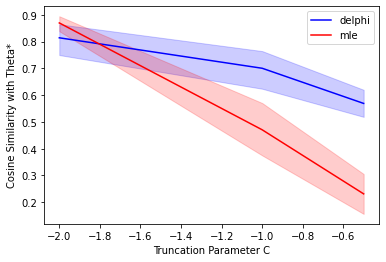

In [8]:
print("all trials:")

# variance vs param mse
sns.lineplot(data=results, x='C', y='delphi_cos', label='delphi', color='blue')
ax = sns.lineplot(data=results, x='C', y='mle_cos', label='mle', color='red')
ax.set(xlabel='Truncation Parameter C', ylabel='Cosine Similarity with Theta*')
plt.show()

In [75]:
noised = Tensor([[[ 1.0560, -3.8584],
         [-1.2214, -0.9489]],

        [[-1.6712, -1.9533],
         [-0.8944, -1.4495]],

        [[-1.8983, -4.0983],
         [-1.4501, -1.9598]],

        [[-0.9539, -2.2767],
         [ 2.5476,  0.4471]],

        [[-2.2341, -2.2865],
         [-1.7169,  0.2144]],

        [[-1.4339, -0.3059],
         [ 0.4510, -1.4590]],

        [[-2.0107, -1.3643],
         [-1.5716,  0.3137]],

        [[-0.7560, -1.4000],
         [-0.9327,  0.1150]],

        [[-2.0108, -2.5165],
         [-0.3383, -0.6087]],

        [[-0.0648, -2.7537],
         [ 1.7234,  1.9073]],

        [[-1.8798, -3.3068],
         [-0.7087, -2.4642]],

        [[-0.2455, -2.1626],
         [-0.3371,  0.0180]],

        [[-2.5813, -2.4287],
         [-0.9224, -2.1847]],

        [[-1.0940, -1.9071],
         [ 0.8468, -2.3331]],

        [[-3.2971, -2.0524],
         [-1.4311, -1.1494]],

        [[-2.6149, -2.6758],
         [-0.7592, -1.1986]],

        [[-2.3288, -1.5224],
         [-0.8951, -0.9140]],

        [[-2.7542, -2.8087],
         [-0.5657, -1.4403]],

        [[-3.4988, -3.0018],
         [ 0.5731, -2.2174]],

        [[-2.4198, -2.1155],
         [-0.5168, -0.5764]],

        [[-2.1924, -3.0091],
         [ 2.0917, -2.6498]],

        [[-1.8525, -0.2391],
         [ 1.7617, -0.2672]],

        [[ 0.7369, -3.4856],
         [-0.5979, -0.7600]],

        [[-2.6055, -2.1767],
         [ 1.0593, -1.3477]],

        [[-0.5726, -0.1534],
         [ 1.0499,  0.4263]],

        [[-1.9888, -3.9787],
         [ 0.4091, -1.4149]],

        [[-1.8296, -2.3222],
         [-0.8472, -0.3118]],

        [[-0.6744, -2.4931],
         [ 2.2560,  0.3748]],

        [[-1.8801, -1.6657],
         [ 3.2183, -1.6286]],

        [[-2.2326, -1.1349],
         [-0.0596, -2.0473]],

        [[-1.3548,  0.5576],
         [ 1.9920,  0.9339]],

        [[-2.8249, -3.0318],
         [-1.1114,  0.5785]],

        [[-1.7085, -1.1466],
         [-0.8857, -0.5736]],

        [[-1.8164, -1.7708],
         [-0.1024,  0.0766]],

        [[-3.0525, -1.9988],
         [ 0.5441, -0.7982]],

        [[-1.7448, -3.1155],
         [ 2.2486, -1.5342]],

        [[-1.9477, -0.1934],
         [ 0.5465, -2.5079]],

        [[-2.6963, -0.2418],
         [ 1.2172,  0.7050]],

        [[-1.8903, -2.9712],
         [ 0.4166, -1.2514]],

        [[-2.0709, -3.1687],
         [ 2.5223, -0.2994]],

        [[-1.8679, -2.7461],
         [-0.6421, -1.9754]],

        [[-2.7887, -2.1825],
         [ 0.0998, -1.3368]],

        [[-3.1074, -0.7717],
         [-0.2210, -0.3437]],

        [[-1.9947, -2.9064],
         [ 0.2664,  1.2022]],

        [[-0.9560, -3.1553],
         [ 1.3751, -1.0426]],

        [[-1.5139, -2.3713],
         [ 2.0548, -0.8236]],

        [[-1.4052, -2.0388],
         [ 1.4332, -0.8124]],

        [[-3.2574, -1.5598],
         [ 1.5965, -1.2019]],

        [[-2.8377, -2.6667],
         [ 1.1232, -1.3367]],

        [[-0.4928, -1.8704],
         [-1.4774,  1.0796]],

        [[-2.6414, -3.4802],
         [ 0.6802, -0.9123]],

        [[-0.8694, -2.9267],
         [ 0.2714,  0.4229]],

        [[-0.4967, -1.5111],
         [-0.2160, -1.1178]],

        [[-1.2289, -2.3436],
         [-1.8865, -1.8925]],

        [[-1.6669, -1.7328],
         [-1.2724,  0.2138]],

        [[-1.4756, -2.7216],
         [ 1.1949,  0.5571]],

        [[ 0.6502, -1.1516],
         [-0.7539, -0.5960]],

        [[-2.3657, -2.1644],
         [-1.7881, -0.6049]],

        [[ 0.1235, -2.4216],
         [-1.6703, -0.6570]],

        [[-1.6081, -2.5614],
         [-1.4984, -1.7102]],

        [[-2.1091, -2.8839],
         [-0.0275, -1.1736]],

        [[ 3.6756, -3.6225],
         [-1.2882, -1.1626]],

        [[-2.6822, -2.9475],
         [-0.2061, -1.2934]],

        [[-2.4984, -1.7418],
         [-0.3344, -0.4563]],

        [[-1.7352, -0.3297],
         [-0.2656, -1.8673]],

        [[-1.6158, -3.4096],
         [-0.6524, -0.5965]],

        [[-0.6415, -2.5327],
         [-1.2740,  0.0516]],

        [[-2.1714,  1.0943],
         [-1.2717, -0.3700]],

        [[-2.9328, -3.7710],
         [-0.5234,  2.3529]],

        [[ 0.5606, -2.2174],
         [-1.5207, -1.3377]],

        [[-2.7490, -2.1677],
         [-0.5915,  2.9936]],

        [[-2.1826, -1.7886],
         [-1.1068,  3.8118]],

        [[-1.1182, -1.6254],
         [-2.0043, -1.7129]],

        [[-2.1996, -3.4555],
         [-0.5052,  0.2362]],

        [[-2.7407, -2.7880],
         [-0.5743, -2.4324]],

        [[-0.1798, -3.5650],
         [ 0.7852, -1.0151]],

        [[-2.3234, -2.7063],
         [-1.3150, -1.1089]],

        [[-1.0531, -2.1752],
         [ 1.2345, -1.0169]],

        [[-2.1998, -2.9319],
         [-1.1831, -2.3023]],

        [[-1.7376, -2.5499],
         [ 0.8526, -0.1788]],

        [[-2.2441, -1.3225],
         [-2.1961, -0.6747]],

        [[ 0.5213,  0.4186],
         [-0.8650, -1.8961]],

        [[-2.4624,  4.6077],
         [-1.1862, -0.0901]],

        [[-2.7908, -2.5028],
         [-1.6535, -0.6785]],

        [[-0.2896, -3.4716],
         [-1.6044, -1.1113]],

        [[-0.4959, -2.1963],
         [-0.0990,  0.2970]],

        [[-1.4091, -4.3429],
         [ 0.7885, -1.0671]],

        [[ 0.1364, -2.6706],
         [ 0.1068, -2.5305]],

        [[-2.9902, -2.2973],
         [ 0.8453,  0.8639]],

        [[-2.5638, -2.7309],
         [ 3.1293,  0.4658]],

        [[-1.5934, -0.3429],
         [-0.9555,  0.0455]],

        [[-1.4570, -4.0055],
         [-0.2121,  1.3399]],

        [[-2.8397, -3.3605],
         [ 0.1341, -0.3108]],

        [[-1.0677, -1.8023],
         [-0.8705,  0.8179]],

        [[-1.3403, -1.8707],
         [ 0.8120, -0.0934]],

        [[-0.6316, -2.6508],
         [ 0.1277, -0.9488]],

        [[-2.3880, -2.4543],
         [-0.8413, -0.7747]],

        [[-2.8221, -2.7989],
         [-0.9182,  0.0289]],

        [[-0.3723, -4.1127],
         [-1.2239,  1.1183]],

        [[-0.4058, -2.8588],
         [ 0.0136, -1.2132]]])
targ = Tensor([1, 0])

In [79]:
noised[:, 0, 1].size()

# iterate over samples within batch
for i in range(noised.size(1)): 
    # get minimum noisy logit for kth class
    z_k_min = ch.min(noised[:, i, targ[i]])
    # remove all noisy logits that exceed minimum z_k_min
    noised[:, i, :targ[i]] = ()

torch.Size([100])

In [77]:
min_ = ch.min(noised[:, 0, 1])

In [46]:
noised[:, :, 1][noised[:, :, 1] > min_]

tensor([-6.6353e-01,  9.2454e-01, -1.3882e+00, -4.2077e-01, -5.1796e-01,
        -2.5875e-02,  1.1469e+00,  1.8420e+00, -7.8114e-01,  3.2464e+00,
        -4.9372e-01,  1.8196e+00, -1.4493e+00, -7.7102e-01, -1.8105e+00,
         1.9806e-01,  3.5968e-02, -1.1108e+00,  1.2389e+00,  5.5595e-01,
        -8.8794e-01,  5.0175e-01, -9.5006e-01, -6.9789e-01, -2.3972e-01,
        -2.5504e-01, -1.2480e-01, -2.0448e-01, -9.9472e-01,  7.7929e-01,
        -1.0189e+00, -8.8779e-01, -2.7169e-01,  9.3906e-01,  5.1272e-01,
         3.2421e+00,  6.3645e-01,  7.5989e-01,  6.5425e-01,  7.1514e-01,
        -4.8394e-01,  6.1486e-01,  1.8244e+00, -1.1723e+00, -6.3182e-01,
        -1.2484e+00,  2.0983e+00, -5.9039e-01,  1.1814e-03, -7.0837e-01,
         1.0561e+00, -3.5399e-01,  2.8613e+00,  9.9123e-01, -1.0549e+00,
        -6.8838e-01,  7.9036e-01, -4.3622e-01, -3.6478e-01, -3.9149e-01,
         1.1706e+00,  1.3072e+00, -3.3425e-01, -3.6908e-01,  1.9358e+00,
        -1.2103e+00, -1.0137e+00, -4.3369e-02,  1.1